In [ ]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

import app.assets.preprocessing as preprocessing
import app.assets.views as views

(df_geo, 
df_order, 
df_order_item, 
df_order_payment, 
df_order_review,
df_product, 
df_seller, 
df_customer, 
df_product_category) = preprocessing.load_raw_data()

2025-10-16 18:17:31.789 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-16 18:17:31.790 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-16 18:17:31.791 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-16 18:17:31.791 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 18:17:31.834 
  command:

    streamlit run /opt/anaconda3/lib/python3.13/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-10-16 18:17:31.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 18:17:31.835 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


📁 Project root: /Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2
📁 Data directories:
   Raw: /Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/data/raw
   Processed: /Users/dsagher/Library/CloudStorage/Dropbox/Documents/school/fall 2025/CMSE 830/midterm_project_2/data/processed


2025-10-16 18:17:32.341 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 18:17:32.342 Thread 'Thread-4': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 18:17:32.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 18:17:32.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [3]:
nulls_geo = df_geo.loc[:,(df_geo.isna().sum() > 0).values]
nulls_orders = df_order.loc[:,(df_order.isna().sum() > 0).values]
nulls_order_item = df_order_item.loc[:,(df_order_item.isna().sum() > 0)]
nulls_order_payment = df_order_payment.loc[:,(df_order_payment.isna().sum() > 0)]
nulls_order_review = df_order_review.loc[:,(df_order_review.isna().sum() > 0)]
nulls_product = df_product.loc[:,(df_product.isna().sum() > 0)]
nulls_seller = df_seller.loc[:,(df_seller.isna().sum() > 0)]
nulls_product_category = df_product_category.loc[:,(df_product_category.isna().sum() > 0)]
nulls_customer = df_customer.loc[:,(df_customer.isna().sum() > 0)]

print("------Nulls------")
print("Geolocation: ", nulls_geo.shape[1] > 1)
print("Orders: ",nulls_orders.shape[1] > 1)
print("Order Item: ",nulls_order_item.shape[1] > 1)
print("Order Payment: ",nulls_order_payment.shape[1] > 1)
print("Order Review: ",nulls_order_review.shape[1] > 1)
print("Product: ",nulls_product.shape[1] > 1)
print("Seller: ",nulls_seller.shape[1] > 1)
print("Product Category: ",nulls_product_category.shape[1] > 1)
print("Customer: ",nulls_customer.shape[1] > 1)

------Nulls------
Geolocation:  False
Orders:  True
Order Item:  False
Order Payment:  False
Order Review:  True
Product:  True
Seller:  False
Product Category:  False
Customer:  False


**Observations:** Nulls found in Orders, Order Review, and Product datasets. 

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/anaconda3/lib/python3.13/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/anaconda3/lib/python3.13/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/opt/anaconda3/lib/python3.13/site-packages/matplotlib/mpl-da

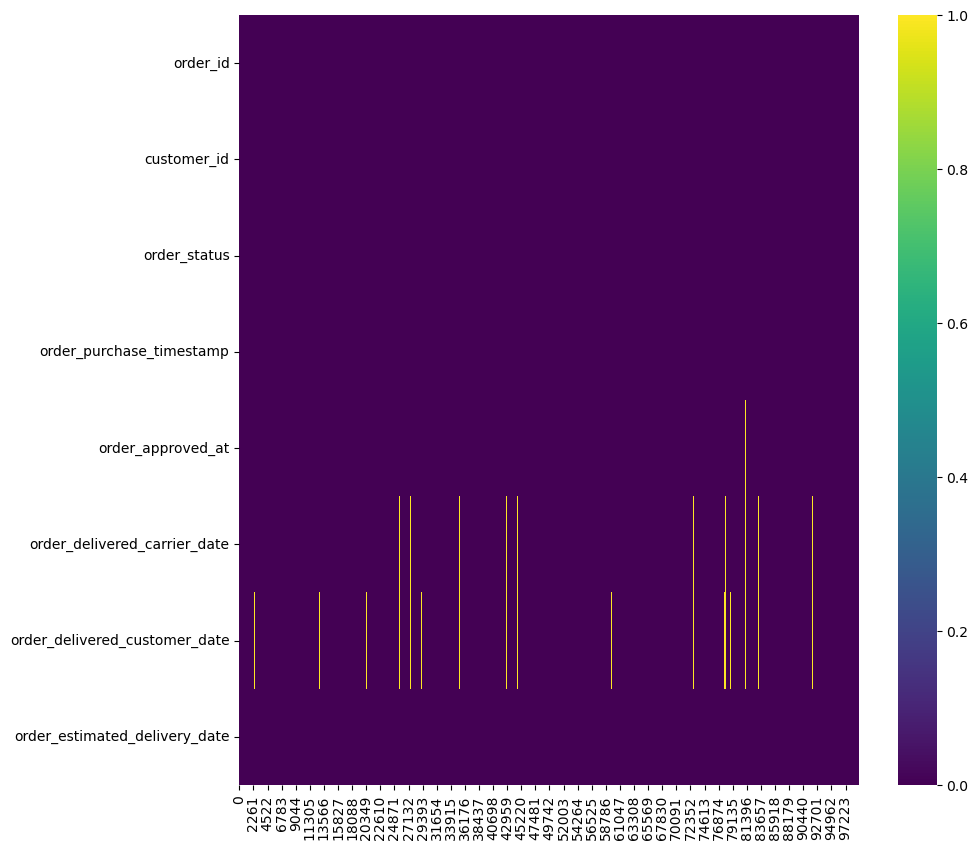

In [4]:
# Show missing values

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_order.isna().transpose(), cmap='viridis', ax=ax)
plt.show()

**Observation:** Missing values cluster around 'order_delivered_customer_date' and 'order_delivered_carrier_date', with some in 'order_approved_at'

**Hypothesis:** Missing values are do to cancellations.

**Next Steps:** Check if there is missing values are found in records with cancelled order status

In [5]:
# Calculate pct of records with missing values and cancelled order status vs pct of records with missing values and not cancelled status

# Whenever customer delivery date is missing, carrier delivery date is missing as well
missing_mask = df_order['order_delivered_customer_date'].isna()
delivered = df_order['order_status'] == 'delivered'
missing_delivery_delivered = len(df_order.loc[missing_mask & delivered])
missing_delivery_not_delivered = len(df_order.loc[missing_mask & ~delivered])
total_orders = len(df_order)

print("Missing delivery values with delivered status:",f'{missing_delivery_delivered / total_orders * 100:.2f}%')
print("Missing delivery values without delivered status",f'{missing_delivery_not_delivered / total_orders * 100:.2f}%')



Missing delivery values with delivered status: 0.01%
Missing delivery values without delivered status 2.97%


**Takeaways:** Only 0.01% of missing values occur in records with 'delivered' status. These are likely due to random error.

**Next Steps:** Determine which delivery status is responsible for the majority of the 2.97% of nulls. 

In [6]:
# All order statuses
df_order["order_status"].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [7]:
# Query for all statuses other than 'delivered'
not_delivered = (df_order.loc[missing_mask & ~ delivered]
                .groupby('order_status')['order_id']
                .count()
                .reset_index()
                .sort_values(by='order_id', ascending=False))

chart = alt.Chart(not_delivered).mark_bar().encode(
    x=alt.X('order_status:N', title='Order Status', sort='-y'),
    y=alt.Y('order_id:Q', title='Count')
).properties(width=750, title='Count of Null Delivery Dates by Order Status')

chart

alt.Chart(...)

**Observations:** Majority of missing nulls are due to legitamate reasons, such as shipping, cancelled, invoiced, etc... Some are unexplained with 'unavailable'. 

**Next Steps:** Look into patterns with 'unavailable' order status

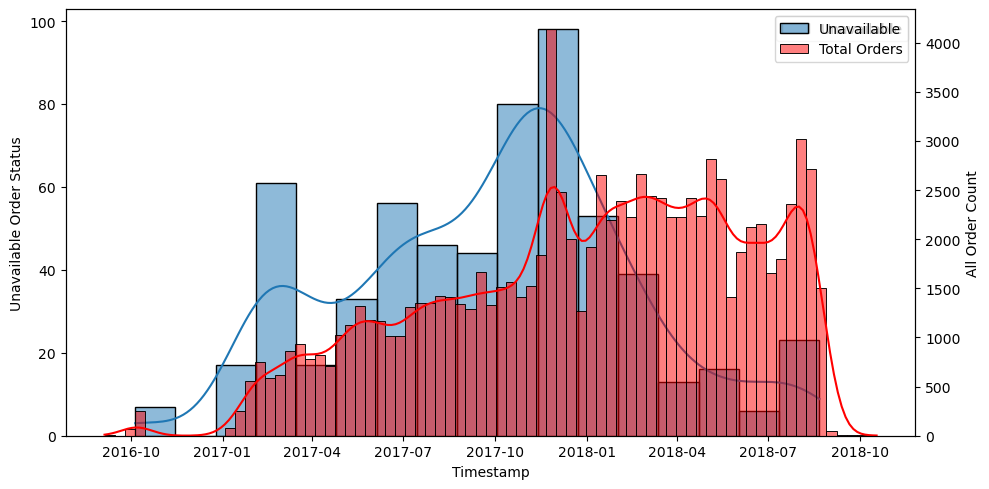

In [8]:
# Filter for only unavailable orders
mask = df_order['order_status'] == 'unavailable'
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])

# Unavailable histogram
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.histplot(df_order.loc[mask], x=df_order.loc[mask, 'order_purchase_timestamp'], ax=ax1, label='Unavailable', kde=True)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Unavailable Order Status')
ax1.legend()

# Total orders histogram
ax2 = ax1.twinx()
sns.histplot(df_order, x='order_purchase_timestamp', ax=ax2, kde=True, color="red", label='Total Orders')
ax2.set_xlabel("All orders")
ax2.set_ylabel("All Order Count")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()




**Observation:** Unavailable order status' follow a similar trend as total orders, indicating that this is due to normal software or human error. 

**Next Steps:** Impute missing values with 'unavailable' order status.

In [9]:
#! Come back to this

mask = df_order['order_status'].isin(['unavailable', 'delivered'])
df_order['order_delivered_customer_date'] = pd.to_datetime(df_order['order_delivered_customer_date'])
df_order['order_delivered_carrier_date'] = pd.to_datetime(df_order['order_delivered_carrier_date'])

filled = (
    df_order[mask]
    .merge(df_order_item, how='left')
    .merge(df_seller, how='left')
    # Impute median zip codes grouped by zip codes
    .groupby('seller_zip_code_prefix')
    .apply(
        lambda g: g.assign(
        # Fill customer delivery date with values from records with order_status as delivered
            order_delivered_customer_date=g['order_delivered_customer_date'].fillna(
                g.loc[g['order_status'] == 'delivered', 'order_delivered_customer_date'].median()
            ),
        # Fill carrier delivery date with values from records with order_status as delivered
            order_delivered_carrier_date=g['order_delivered_carrier_date'].fillna(
                g.loc[g['order_status'] == 'delivered', 'order_delivered_carrier_date'].median()
            )
        )
    )
    .reset_index(drop=True)
)


/var/folders/tk/d53sqng90z98zzrcds69cqbc0000gn/T/ipykernel_86643/1884087250.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [10]:
# Verify imputation
print("Nulls before:", df_order['order_delivered_customer_date'].isna().sum())
df_order = filled  # or whatever your imputed df is called
print("Nulls after:", df_order['order_delivered_customer_date'].isna().sum())

Nulls before: 2965
Nulls after: 2


In [ ]:
# Add customer spending column

merged = pd.merge(df_customer, df_order, on='customer_id', how='inner')
merged = pd.merge(merged, df_order_payment, on='order_id', how='inner')
customer_spending = merged.groupby('customer_id')['payment_value'].sum().to_frame()

# Discretize spending
kbd = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# Fit and transform
kbd.fit(customer_spending)
customer_spending['customer_spending'] = kbd.transform(customer_spending)

# Merge with customer dataset
df_customer = pd.merge(df_customer, customer_spending, on='customer_id', how='inner')
